In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
# !ls 

In [3]:
train_path = "mirror_data/training"
validation_path = "original_data/validation"
test_path = "original_data/test"

In [4]:
dimentions = (299, 299)
batch_size = 64

n_class = 2

In [5]:
train_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [6]:
valid_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 1434 images belonging to 2 classes.


In [8]:
validation_generator = valid_datagen.flow_from_directory(
    validation_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [9]:
test_generator = valid_datagen.flow_from_directory(
    test_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from keras.models import Model

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
)

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
predictions = Dense(n_class, activation='softmax')(x)    
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
from keras import metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [12]:
from keras.callbacks import ModelCheckpoint  

# !mkdir saved_models

model_file = 'saved_models/mirror_weights.best.InceptionV3.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [13]:
epochs = 10

In [14]:
train_history = model.fit_generator(train_generator, 
                                    validation_data=validation_generator, 
                                    epochs=epochs, 
                                    callbacks=[checkpointer],
                                    steps_per_epoch=train_generator.samples // batch_size, 
                                    validation_steps=validation_generator.samples // batch_size
                                   )

Epoch 1/10
22/22 [==============================] - 189s 9s/step - loss: 0.1940 - acc: 0.9339 - val_loss: 2.8858 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 2.88577, saving model to saved_models/mirror_weights.best.InceptionV3.hdf5
Epoch 2/10
22/22 [==============================] - 105s 5s/step - loss: 0.1580 - acc: 0.9374 - val_loss: 0.2812 - val_acc: 0.8971

Epoch 00002: val_loss improved from 2.88577 to 0.28123, saving model to saved_models/mirror_weights.best.InceptionV3.hdf5
Epoch 3/10
22/22 [==============================] - 136s 6s/step - loss: 0.1386 - acc: 0.9465 - val_loss: 0.1817 - val_acc: 0.9657

Epoch 00003: val_loss improved from 0.28123 to 0.18166, saving model to saved_models/mirror_weights.best.InceptionV3.hdf5
Epoch 4/10
22/22 [==============================] - 140s 6s/step - loss: 0.0741 - acc: 0.9720 - val_loss: 0.3353 - val_acc: 0.9257

Epoch 00004: val_loss did not improve from 0.18166
Epoch 5/10
22/22 [==============================] - 146s 7s

In [15]:
train_history.history

{'val_loss': [2.885772625605265,
  0.2812301920141493,
  0.18166280831609455,
  0.33533662966319494,
  0.27712832887967426,
  0.36990234340940203,
  0.18881127187183924,
  0.22918609167848314,
  0.4406540095806122,
  0.46495345899036955],
 'val_acc': [0.75,
  0.8971428605488369,
  0.9657142863954816,
  0.9257142891202654,
  0.9739583333333334,
  0.9600000013623918,
  0.9600000020435878,
  0.9028571462631225,
  0.875,
  0.8742857176916939],
 'loss': [0.19399089908057993,
  0.1568615354978255,
  0.1355330328871734,
  0.07280452858357533,
  0.05691659168822922,
  0.045768409108158443,
  0.06154863697605847,
  0.045142065105538295,
  0.04897245477042059,
  0.019620533385416018],
 'acc': [0.9339488636363636,
  0.9408759120607028,
  0.9481751820466814,
  0.9722627732005432,
  0.9781021892589374,
  0.9854014598540146,
  0.9700729927007299,
  0.9854014598540146,
  0.9788321162662367,
  0.9934306569343065]}

In [16]:
import matplotlib.pyplot as plt

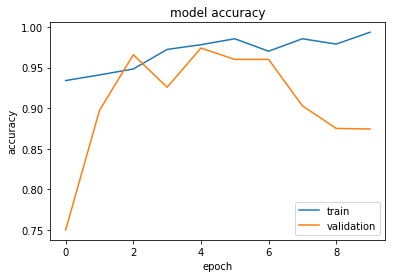

In [17]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

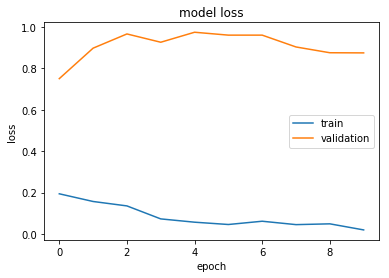

In [18]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [35]:
model.load_weights(model_file)
tesr_result = model.evaluate_generator(test_generator, steps=10)

In [36]:
tesr_result

[0.835035602094887, 0.9134125650839814]

In [37]:
predict = model.predict_generator(test_generator,steps = 10)

In [38]:
import cv2
import numpy as np


from keras.preprocessing import image
# img = cv2.imread(path_to_one_file)
# img = np.array([img]).reshape((1, 3, 299, 299))

def to_tensor(img_path): 
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    
    return img_tensor

In [39]:
def make_predict(img_path): 
    class_dic = {}
    for k, v in test_generator.class_indices.items():
        class_dic[v] = k
    
    
    y_prob = model.predict(to_tensor(img_path))
    y_classes = y_prob.argmax(axis=-1)
    return class_dic[y_classes[0]]

In [40]:
img_path = "original_data/test/benign/ISIC_0004472.jpg"
make_predict(img_path)

'benign'

In [41]:
class_dic = dict(test_generator.class_indices)
print(class_dic)

one_hot = {}
for k, v in test_generator.class_indices.items():
    one_hot[v] = k
print(one_hot)

{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


In [42]:
from os import listdir 

y_true = [] 
y_pred = []

class_name = "benign"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    
class_name = "malignant"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    

In [43]:
len(y_true) == len(y_pred)

True

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["benign", "malignant"])

In [45]:
import pandas as pd
df_cm = pd.DataFrame(cm, ["benign", "malignant"], ["benign", "malignant"])

In [46]:
import seaborn as sn

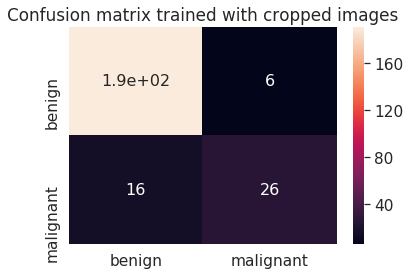

In [47]:
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("Confusion matrix trained with cropped images")# font size
plt.show()

In [48]:
from sklearn.metrics import f1_score
y_true_01 = [class_dic[p] for p in y_true]
y_pred_01 = [class_dic[p] for p in y_pred]
f1_score(y_true_01, y_pred_01)

0.7027027027027026

In [49]:
from sklearn.metrics import recall_score
recall_score(y_true_01, y_pred_01) 

0.6190476190476191

In [50]:
from sklearn.metrics import precision_score
precision_score(y_true_01, y_pred_01) 

0.8125

In [51]:
# y_pred_01